In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.arima.model import ARIMA

In [151]:
#Load Data
df = pd.read_csv('coffee_sales(1).csv')
df.head(10)

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,month,sales
0,1,2023-10-23,10:35:58,1,10,Upper East Side,94,3.64,Coffee,Barista Espresso,Cappuccino Sm,October,3.64
1,2,2023-07-19,08:30:24,1,4,Upper East Side,36,2.83,Coffee,Gourmet brewed coffee,Columbian Medium Roast Sm,July,2.83
2,3,2023-06-30,18:28:53,3,2,Midtown,35,2.70,Bakery,Muffin,Chocolate Chip Muffin,June,8.10
3,4,2023-06-29,06:44:28,3,8,Brooklyn,12,3.59,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,June,10.77
4,5,2023-01-09,12:22:37,2,7,Upper East Side,54,3.32,Bakery,Muffin,Blueberry Muffin,January,6.64
5,6,2023-05-14,14:26:15,2,6,Midtown,14,2.99,Bakery,Scone,Blueberry Scone,May,5.98
6,7,2023-03-24,20:11:25,1,7,Upper East Side,90,4.39,Drinking Chocolate,Hot chocolate,Classic Cocoa Sm,March,4.39
7,8,2023-12-06,14:37:19,1,7,Upper East Side,13,2.99,Bakery,Scone,Oatmeal Scone,December,2.99
8,9,2023-02-17,06:14:30,3,3,Lower Manhattan,79,4.67,Drinking Chocolate,Hot chocolate,Classic Cocoa Sm,February,14.01
9,10,2023-10-17,19:12:22,3,1,Queens,23,2.77,Coffee,Gourmet brewed coffee,Columbian Medium Roast Sm,October,8.31


#Data Cleaning

In [152]:
#checking fornnulls
df.isnull().sum()

,0
transaction_id,0
transaction_date,0
transaction_time,0
transaction_qty,0
store_id,0
store_location,0
product_id,0
unit_price,0
product_category,0
product_type,0


In [122]:
# dropping "product_id" and "store_id"
df.drop(columns = ["store_id", "product_id"], inplace = True)

In [123]:

#rename columns
df.rename(columns = {'transaction_id': 'id',
                     'transaction_date': 'date',
                     'transaction_time': 'time',
                     'transaction_qty': 'quantity',
                     'store_location': 'location',
                     'product_category': 'category',
                     'product_type': 'product',
                     'product_detail': 'detail'}, inplace = True)

In [174]:
df['date'] = pd.to_datetime(df['date'])

df['year'] = df['date'].dt.year
df['day'] = df['date'].dt.day
df['hour'] = pd.to_datetime(df['transaction_time'], format='%H:%M:%S').dt.hour


In [159]:
# summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_id    2000 non-null   int64         
 1   transaction_date  2000 non-null   object        
 2   transaction_time  2000 non-null   object        
 3   transaction_qty   2000 non-null   int64         
 4   store_id          2000 non-null   int64         
 5   store_location    2000 non-null   object        
 6   product_id        2000 non-null   int64         
 7   unit_price        2000 non-null   float64       
 8   product_category  2000 non-null   object        
 9   product_type      2000 non-null   object        
 10  product_detail    2000 non-null   object        
 11  month             2000 non-null   object        
 12  sales             2000 non-null   float64       
 13  date              2000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), fl

In [175]:
# converting date to datetime
df['date'] = pd.to_datetime(df['transaction_date'], dayfirst=True)

/tmp/ipython-input-3493729606.py:2: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['date'] = pd.to_datetime(df['transaction_date'], dayfirst=True)


In [169]:
df['sales']

,sales
0,3.64
1,2.83
2,8.10
3,10.77
4,6.64
...,...
1995,2.00
1996,6.72
1997,5.08
1998,3.37


#Time and Day Feature

In [176]:
def get_time_of_day(hour):
    if hour < 12:
        return 'Morning'
    elif hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

df['time_of_day'] = df['hour'].apply(get_time_of_day)


#EDA & Metrics

In [177]:
sns.set_palette(sns.color_palette("RdBu"))
plt.rcParams['figure.figsize'] = (8, 4)


#Cost & Profit Analysis

In [178]:
# Business assumption
df['cost'] = df['sales'] * 0.60
df['profit'] = df['sales'] - df['cost']

print("Total Sales:", round(df['sales'].sum(), 2))
print("Total Cost:", round(df['cost'].sum(), 2))
print("Total Profit:", round(df['profit'].sum(), 2))


Total Sales: 13716.02
Total Cost: 8229.61
Total Profit: 5486.41


#Profit By Category

In [180]:
profit_summary = (
    df.groupby('product_category')[['sales', 'cost', 'profit']]
    .sum()
    .sort_values(by='profit', ascending=False)
)

profit_summary


,sales,cost,profit
product_category,,,
Drinking Chocolate,4119.52,2471.712,1647.808
Tea,3714.09,2228.454,1485.636
Coffee,3301.80,1981.080,1320.720
Bakery,2580.61,1548.366,1032.244


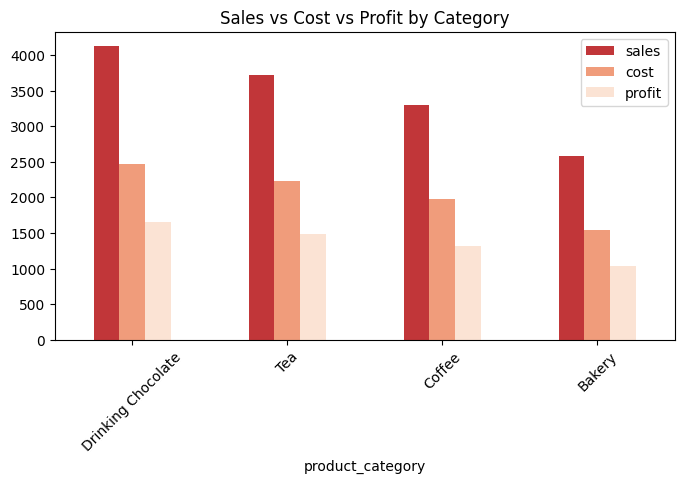

In [181]:
profit_summary.plot(kind='bar')
plt.title("Sales vs Cost vs Profit by Category")
plt.xticks(rotation=45)
plt.show()


#EDA Visualizations

In [182]:
#Sales by Month
month_order = [
    'January','February','March','April','May','June',
    'July','August','September','October','November','December'
]

monthly_sales = df.groupby('month', as_index=False)['sales'].sum()
monthly_sales['month'] = pd.Categorical(
    monthly_sales['month'],
    categories=month_order,
    ordered=True
)
monthly_sales = monthly_sales.sort_values('month')


<function matplotlib.pyplot.show(close=None, block=None)>

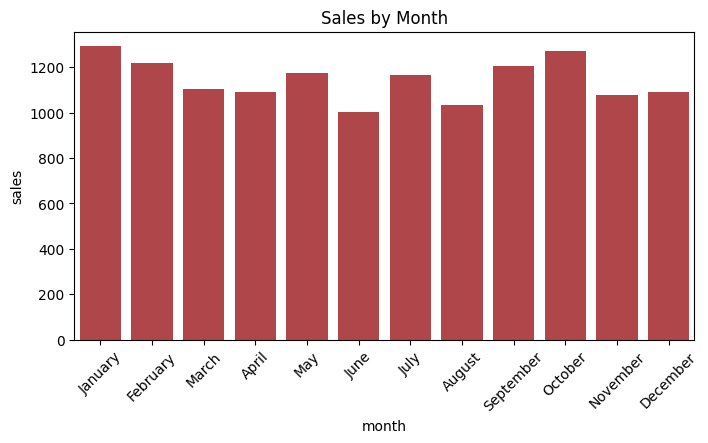

In [183]:
sns.barplot(data=monthly_sales, x='month', y='sales', errorbar=None)
plt.title('Sales by Month')
plt.xticks(rotation=45)
plt.show

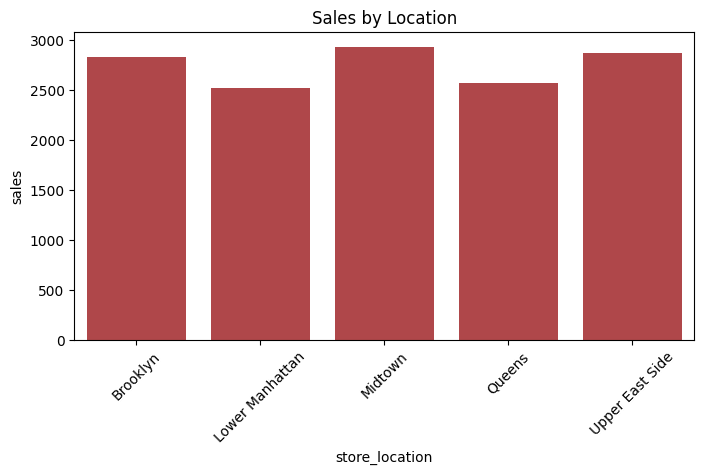

In [186]:
#Sales by location
location_revenue = df.groupby('store_location')['sales'].sum().reset_index()

sns.barplot(data=location_revenue, x='store_location', y='sales', errorbar=None)
plt.title('Sales by Location')
plt.xticks(rotation=45)
plt.show()


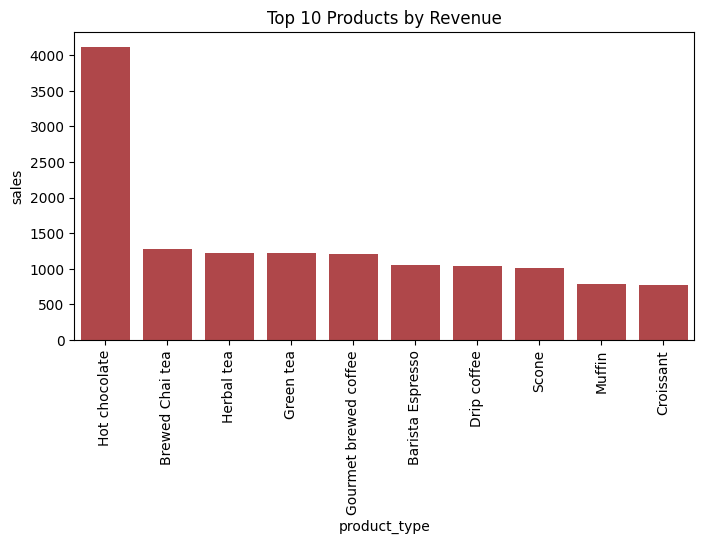

In [188]:
#Top 10 Products by Revenue
product_revenue = df.groupby('product_type')['sales'].sum().reset_index()

sns.barplot(
    data=product_revenue.sort_values('sales', ascending=False).head(10),
    x='product_type', y='sales'
)
plt.xticks(rotation=90)
plt.title('Top 10 Products by Revenue')
plt.show()


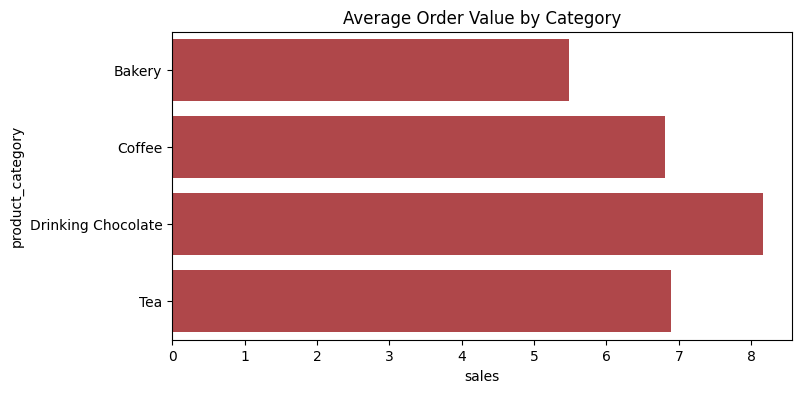

In [190]:
#Average order value by category
category_aov = df.groupby('product_category')['sales'].mean().reset_index()

sns.barplot(data=category_aov, x='sales', y='product_category')
plt.title('Average Order Value by Category')
plt.show()


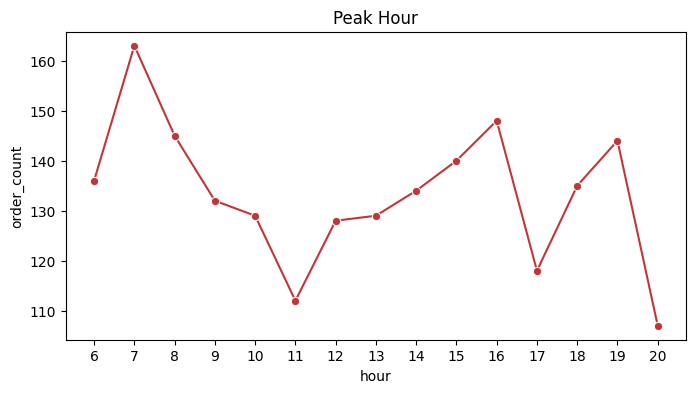

In [192]:
#Peak Hour Analysis
order_per_hour = df.groupby('hour')['transaction_id'].count().reset_index(name='order_count')

sns.lineplot(data=order_per_hour, x='hour', y='order_count', marker='o')
plt.title('Peak Hour')
plt.xticks(range(order_per_hour['hour'].min(), order_per_hour['hour'].max()+1))
plt.show()


#Future Sales Forcasting

In [193]:
#Arima forcast
daily_sales = df.groupby('date')['sales'].sum()

model = ARIMA(daily_sales, order=(3,1,2))
model_fit = model.fit()

future_sales = model_fit.forecast(steps=30)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

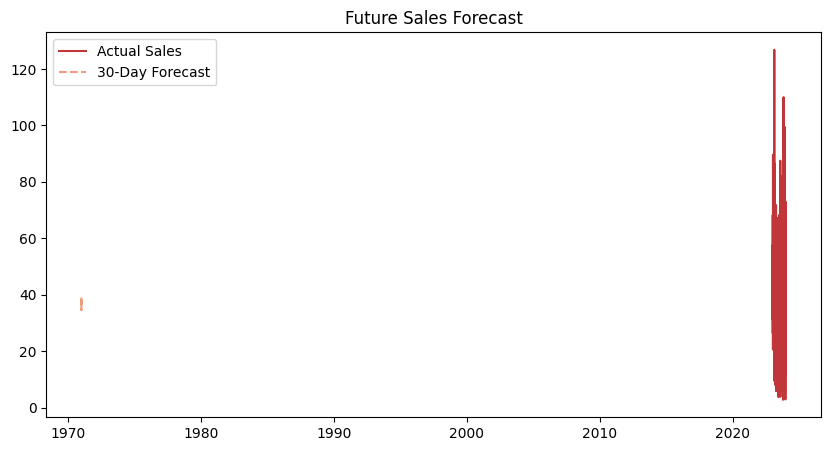

In [194]:
plt.figure(figsize=(10,5))
plt.plot(daily_sales, label='Actual Sales')
plt.plot(future_sales, label='30-Day Forecast', linestyle='--')
plt.legend()
plt.title("Future Sales Forecast")
plt.show()


#Interactive Charts


In [196]:
fig1 = px.bar(
    profit_summary.reset_index(),
    x='product_category',
    y='profit',
    title='Profit by Category'
)
fig1.show()


In [197]:
fig2 = px.line(
    daily_sales.reset_index(),
    x='date',
    y='sales',
    title='Sales Trend Over Time'
)
fig2.show()
